In [1]:
import zipfile
import os
import random
import pandas as pd
import numpy as np
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
import torch
import cv2
from google.colab.patches import cv2_imshow


In [2]:
DATASETS = [8,9,10,11,12]
for dataset in DATASETS:
  zip_file_path = f"/content/drive/MyDrive/Practicum_Autonomous/TUMsimulator/Dataset{dataset}.zip"  # Replace with the actual zip file path
  destination_folder = "/content/Simulator"  # Replace with the desired destination folder

  with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
      zip_ref.extractall(destination_folder)

### Resnet

In [3]:
def resnet_model(weights='ResNet50_Weights.IMAGENET1K_V2'):
    model = models.resnet50(weights = weights)
    model.fc = nn.Sequential(
        nn.Linear(in_features=2048, out_features=512),
        nn.ELU(),
        nn.Linear(in_features=512, out_features=256),
        nn.ELU(),
        nn.Linear(in_features=64, out_features=1)
        )
    return model

### Nvidia model

In [2]:
# # This used for the pretrained udacity model
# class NetworkNvidia(nn.Module):
#     """
#     Initialize NVIDIA model.
#       Image normalization to avoid saturation and make gradients work better.
#       Convolution: 5x5, filter: 24, strides: 2x2, activation: ELU
#       Convolution: 5x5, filter: 36, strides: 2x2, activation: ELU
#       Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU
#       Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
#       Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
#       Drop out (0.5)
#       Fully connected: neurons: 100, activation: ELU
#       Fully connected: neurons: 50, activation: ELU
#       Fully connected: neurons: 10, activation: ELU
#       Fully connected: neurons: 1 ("output: steering")
#     """
#     def __init__(self):
#         super().__init__()
#         self.nvidia = nn.Sequential(
#             nn.Conv2d(3, 24, 5, stride=2),
#             nn.ELU(),
#             nn.Conv2d(24, 36, 5, stride=2),
#             nn.ELU(),
#             nn.Conv2d(36, 48, 5, stride=2),
#             nn.ELU(),
#             nn.Conv2d(48, 64, 3),
#             nn.ELU(),
#             nn.Conv2d(64, 64, 3),
#             nn.Dropout(0.5),
#             nn.Flatten(),
#             nn.Linear(1152, 100),
#             nn.ELU(),
#             nn.Linear(100, 50),
#             nn.ELU(),
#             nn.Linear(50, 10),
#             nn.ELU(),
#             nn.Linear(10, 1),
#         )
#     """
#     * @brief Function to build the model.
#     * @parma The image to train.
#     * @return The trained prediction network.
#     """
#     def forward(self, input):
#         input = self.nvidia(input)
#         return input

class NetworkNvidia(nn.Module):
    """NVIDIA model used in the paper."""

    def __init__(self):
        """Initialize NVIDIA model.

        NVIDIA model used
            Image normalization to avoid saturation and make gradients work better.
            Convolution: 5x5, filter: 24, strides: 2x2, activation: ELU
            Convolution: 5x5, filter: 36, strides: 2x2, activation: ELU
            Convolution: 5x5, filter: 48, strides: 2x2, activation: ELU
            Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
            Convolution: 3x3, filter: 64, strides: 1x1, activation: ELU
            Drop out (0.5)
            Fully connected: neurons: 100, activation: ELU
            Fully connected: neurons: 50, activation: ELU
            Fully connected: neurons: 10, activation: ELU
            Fully connected: neurons: 1 ("outputs: throttle, brakes, steering")

        the convolution layers are meant to handle feature engineering.
        the fully connected layer for predicting the steering angle.
        the elu activation function is for taking care of vanishing gradient problem.
        """
        super(NetworkNvidia, self).__init__()
        self.conv_layers = nn.Sequential(
            nn.Conv2d(3, 24, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(24, 36, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(36, 48, 5, stride=2),
            nn.ELU(),
            nn.Conv2d(48, 64, 3),
            nn.ELU(),
            nn.Conv2d(64, 64, 3),
            nn.Dropout(0.5)
        )
        self.linear_layers = nn.Sequential(
            nn.Linear(in_features=64 * 18, out_features=100),
            nn.ELU(),
            nn.Linear(in_features=100, out_features=50),
            nn.ELU(),
            nn.Linear(in_features=50, out_features=10),
            nn.Linear(in_features=10, out_features=1)
        )

    def forward(self, input):
        """Forward pass."""
        input = input.view(input.size(0), 3, 66, 200)
        output = self.conv_layers(input)
        # print(output.shape)
        output = output.view(output.size(0), -1)
        output = self.linear_layers(output)
        return output

### Fetch data - Preprocessing

In [3]:

# READ DATASET8

data_path = '/content/Simulator/Dataset8/VehicleData.txt'
folder_dir = os.path.dirname(data_path)
head, tail = os.path.split(data_path)

with open(data_path, 'r') as f:
  lines = f.readlines()

dataset = []
for data in lines:
  img_path, throttle, brakes, steering =  data.strip('\n').split(' ')
  img_path = img_path.strip("/")
  dataset.append([os.path.join(head,img_path), float(throttle), float(brakes), float(steering)])


df_1 = pd.DataFrame(dataset, columns=['image_path', 'throttle', 'brakes', 'steering'])



In [4]:
# READ DATASET9

data_path = '/content/Simulator/Dataset9/VehicleData.txt'
folder_dir = os.path.dirname(data_path)
head, tail = os.path.split(data_path)

with open(data_path, 'r') as f:
  lines = f.readlines()

dataset = []
for data in lines:
  img_path, throttle, brakes, steering =  data.strip('\n').split(' ')
  img_path = img_path.strip("/")
  dataset.append([os.path.join(head,img_path), float(throttle), float(brakes), float(steering)])

df_2 = pd.DataFrame(dataset, columns=['image_path', 'throttle', 'brakes', 'steering'])

In [5]:
# READ DATASET10

data_path = '/content/Simulator/Dataset10/VehicleData.txt'
folder_dir = os.path.dirname(data_path)
head, tail = os.path.split(data_path)

with open(data_path, 'r') as f:
  lines = f.readlines()

dataset = []
for data in lines:
  img_path, throttle, brakes, steering =  data.strip('\n').split(' ')
  img_path = img_path.strip("/")
  dataset.append([os.path.join(head,img_path), float(throttle), float(brakes), float(steering)])

df_3 = pd.DataFrame(dataset, columns=['image_path', 'throttle', 'brakes', 'steering'])

In [6]:
# READ DATASET11

data_path = '/content/Simulator/Dataset11/VehicleData.txt'
folder_dir = os.path.dirname(data_path)
head, tail = os.path.split(data_path)

with open(data_path, 'r') as f:
  lines = f.readlines()

dataset = []
for data in lines:
  img_path, throttle, brakes, steering =  data.strip('\n').split(' ')
  img_path = img_path.strip("/")
  dataset.append([os.path.join(head,img_path), float(throttle), float(brakes), float(steering)])

df_4 = pd.DataFrame(dataset, columns=['image_path', 'throttle', 'brakes', 'steering'])

In [7]:
# READ DATASET12

data_path = '/content/Simulator/Dataset12/VehicleData.txt'
folder_dir = os.path.dirname(data_path)
head, tail = os.path.split(data_path)

with open(data_path, 'r') as f:
  lines = f.readlines()

dataset = []
for data in lines:
  img_path, throttle, brakes, steering =  data.strip('\n').split(' ')
  img_path = img_path.strip("/")
  dataset.append([os.path.join(head,img_path), float(throttle), float(brakes), float(steering)])

df_5 = pd.DataFrame(dataset, columns=['image_path', 'throttle', 'brakes', 'steering'])

In [29]:
df = pd.concat([df_1, df_2, df_3, df_4, df_5])

<Axes: ylabel='Frequency'>

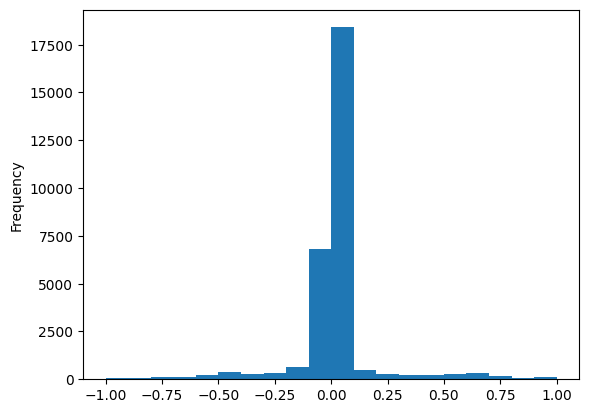

In [30]:
df['steering'].plot.hist(bins=20)

In [32]:
N = 5500
zero_steering_rows = df[df['steering'] == 0.0].index

if len(zero_steering_rows) >= N:
    rows_to_remove = zero_steering_rows[:N]
    df = df.drop(rows_to_remove, axis=0)
    print(f"Now the dataset contains: {len(df)}")
else:
    print(f"Number of rows with steering value 0.0 is less than the desired number of rows to remove. Number of rows with 0.0 {len(zero_steering_rows)}")

Now the dataset contains: 14708


In [33]:
zero_df = df.query("steering == 0.0").sample(frac=.1)
len(zero_df)

350

<Axes: ylabel='Frequency'>

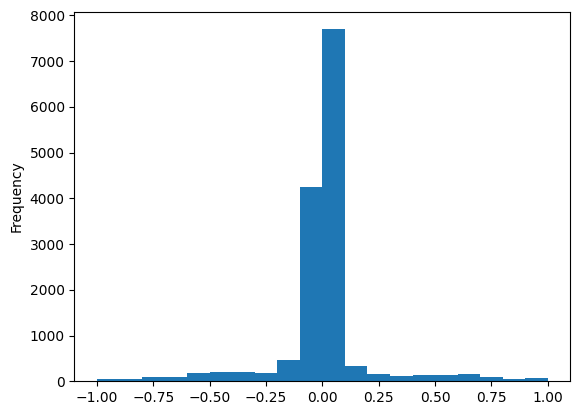

In [41]:
df['steering'].plot.hist(bins=20)

In [42]:
df['steering'].median

<bound method NDFrame._add_numeric_operations.<locals>.median of 0      -0.015625
1      -0.015625
2      -0.015625
3      -0.015625
4      -0.015625
          ...   
3326   -0.006250
3327   -0.006250
3328   -0.006250
3329   -0.006250
3700   -0.003125
Name: steering, Length: 14708, dtype: float64>

In [43]:
## drop N rows with steering near median
N = 11500
threshold = 0.015
near_zero_rows = df[np.abs(df['steering']) <= threshold]
print(f"removing: {min(N, len(near_zero_rows))}")
indices_to_remove = near_zero_rows.sample(min(N, len(near_zero_rows))).index

clean_df = df.drop(indices_to_remove, axis=0)

removing: 8414


In [44]:
len(clean_df)

2264

In [45]:
clean_df['steering'].median

<bound method NDFrame._add_numeric_operations.<locals>.median of 3835    0.040625
3836    0.040625
3837    0.040625
3838    0.040625
3839    0.037500
          ...   
6130   -0.046875
6131   -0.046875
6132   -0.046875
6133   -0.046875
6134   -0.037500
Name: steering, Length: 2264, dtype: float64>

In [46]:
## drop N rows with steering near median
N = 2500
threshold = 0.04
near_zero_rows = clean_df[np.abs(clean_df['steering']) <= threshold]
print(f"removing: {min(N, len(near_zero_rows))}")
indices_to_remove = near_zero_rows.sample(min(N, len(near_zero_rows))).index

clean_df = clean_df.drop(indices_to_remove, axis=0)

removing: 634


<Axes: ylabel='Frequency'>

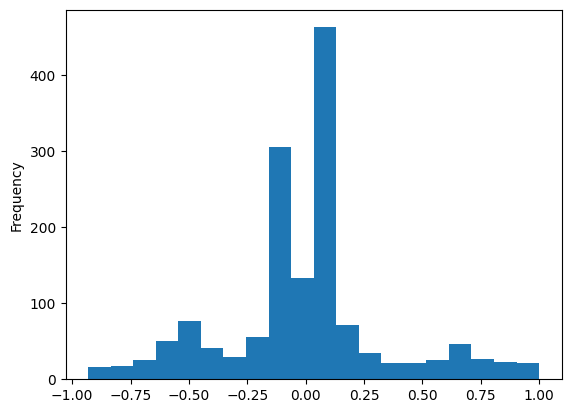

In [47]:
clean_df['steering'].plot.hist(bins=20)

In [48]:
# IMAGE_SIZE = (224, 224) # FOR RESNET
IMAGE_SIZE = (200, 66)

def random_blur(image, max_kernel_size=5):
    """
    Applies a random blur effect to the input image.

    Parameters:
        image (numpy array): The input image (numpy array) to be blurred.
        max_kernel_size (int): The maximum size of the Gaussian blur kernel.
                               The actual kernel size will be a random integer
                               between 1 and max_kernel_size.

    Returns:
        numpy array: The blurred image.
    """
    # Randomly choose a kernel size for Gaussian blur
    kernel_size = random.randint(1, max_kernel_size) * 2 + 1

    # Apply Gaussian blur with the randomly chosen kernel size
    blurred_image = cv2.GaussianBlur(image, (kernel_size, kernel_size), 0)

    return blurred_image

def random_contrast(image, min_factor=0.5, max_factor=1.5):
    # Generate a random contrast factor within the specified range
    contrast_factor = np.random.uniform(min_factor, max_factor)

    # Adjust the pixel intensity values using the contrast factor
    adjusted_image = cv2.convertScaleAbs(image, alpha=contrast_factor, beta=0)

    return adjusted_image

def random_brightness(image, min_value=-60, max_value=60):
    # Generate a random brightness value within the specified range
    brightness_value = np.random.randint(min_value, max_value + 1)

    # Adjust the pixel intensity values using the brightness value
    adjusted_image = np.clip(image.astype(np.int16) + brightness_value, 0, 255).astype(np.uint8)

    return adjusted_image

def crop_and_get_center_image(image):
    sub_image_width = image.shape[1] // 3

    # Calculate the starting and ending indices for the middle portion
    start_index = sub_image_width
    end_index = sub_image_width * 2

    # Crop the middle portion of the image
    cropped_img = image[:, start_index:end_index, :]

    return cropped_img

def crop_sky(image):

    return image[65:, :, :]

def rgb2yuv(image):
    return cv2.cvtColor(image, cv2.COLOR_RGB2YUV)

In [28]:
!rm -r /content/drive/MyDrive/Practicum_Autonomous/augmented_image

In [49]:
# Upsampling images with steering angle not zero
import uuid

def augment_and_save_image(row):
    image_path = row['image_path']

    # Read the image using OpenCV
    image = cv2.imread(image_path)

    image = random_contrast(image)
    image = random_brightness(image)
    image = random_blur(image)
    path = "/content/drive/MyDrive/Practicum_Autonomous/augmented_image/" + str(uuid.uuid4()) + ".jpg"
    cv2.imwrite(path,image)

    path, filename = os.path.split(image_path)

    # Save the augmented image
    save_path = os.path.join(path, "Augmented_CapturedImage.png")
    cv2.imwrite(save_path, image)

    # Update the image path in the row
    row['image_path'] = save_path
    return row



In [50]:
threshold = 0.25
non_zero_rows = df[np.abs(df['steering']) >= threshold]
print(len(non_zero_rows))

augmented_df = non_zero_rows.apply(augment_and_save_image, axis=1)

1807


In [51]:
final_df = pd.concat([zero_df, augmented_df])

<Axes: ylabel='Frequency'>

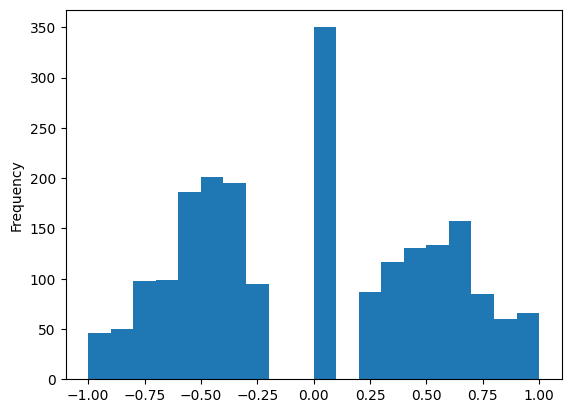

In [52]:
final_df['steering'].plot.hist(bins=20)

In [53]:
final_df["image_path"].head()

3095    /content/Simulator/Dataset9/IMG/sub3095/Captur...
1338    /content/Simulator/Dataset10/IMG/sub1338/Captu...
11      /content/Simulator/Dataset9/IMG/sub11/Captured...
421     /content/Simulator/Dataset12/IMG/sub421/Captur...
2464    /content/Simulator/Dataset9/IMG/sub2464/Captur...
Name: image_path, dtype: object

In [54]:
# WRITE DATAFRAME TO CSV
final_df.to_csv("/content/Simulator/dataset.csv", index=False)

In [125]:
import os
import cv2
import numpy as np
import torch
from torch.utils.data import Dataset

from google.colab.patches import cv2_imshow


def apply_transformations(image):
    img = crop_and_get_center_image(image)
    img = crop_sky(img)
    img = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
    img = cv2.resize(img, IMAGE_SIZE)
    # img = random_blur(img, 3)
    # img = random_contrast(img)
    # img = random_brightness(img)
    # cv2_imshow(img)
    return img

class SimulatorDataset(Dataset):
    def __init__(self, data_path, phase='train'):

      self.folder_dir = os.path.dirname(data_path)
      with open(data_path, 'r') as f:
          self.lines = f.readlines()

    def __len__(self):
        return len(self.lines)

    def __getitem__(self, idx):
        img, throttle, brakes, steering = self.lines[idx].strip('\n').split(' ')
        img = img.strip("/")
        img = cv2.imread(os.path.join(self.folder_dir, img))
        img = apply_transformations(img)
        img = img.astype(np.float32)
        img = torch.from_numpy(img).permute(2,0,1)

        return img, torch.from_numpy(np.array([throttle, brakes, steering]).astype(np.float32))


class SimulatorDatasetDataframe(Dataset):
    def __init__(self, csv_path, phase='train'):
        self.data = pd.read_csv(csv_path)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Get the sample at the specified index
        sample = self.data.iloc[idx]

        # Extract the features and label from the sample
        img_path, throttle, brakes, steering = sample

        img = cv2.imread(img_path)
        img = apply_transformations(img)
        img = img.astype(np.float32)/255
        img = torch.from_numpy(img).permute(2,0,1)


        return img, torch.from_numpy(np.array([throttle, brakes, steering]).astype(np.float32))

        return features, label


In [126]:
dataset = SimulatorDatasetDataframe(csv_path = '/content/Simulator/dataset.csv')

dataset[10][0]


tensor([[[0.3216, 0.3255, 0.1765,  ..., 0.2196, 0.2235, 0.2353],
         [0.3255, 0.3255, 0.1725,  ..., 0.2118, 0.2275, 0.2353],
         [0.3255, 0.3255, 0.1686,  ..., 0.2196, 0.2431, 0.2275],
         ...,
         [0.1608, 0.1608, 0.1569,  ..., 0.1137, 0.0980, 0.1020],
         [0.1725, 0.1647, 0.1647,  ..., 0.1098, 0.1216, 0.1176],
         [0.1255, 0.1137, 0.1020,  ..., 0.1020, 0.1098, 0.1176]],

        [[0.4941, 0.4902, 0.4980,  ..., 0.4902, 0.4902, 0.4863],
         [0.4902, 0.4902, 0.4980,  ..., 0.4941, 0.4902, 0.4902],
         [0.4902, 0.4902, 0.4980,  ..., 0.4902, 0.4863, 0.4902],
         ...,
         [0.5059, 0.5059, 0.5059,  ..., 0.5020, 0.5020, 0.5020],
         [0.5098, 0.5059, 0.5059,  ..., 0.5020, 0.5020, 0.5020],
         [0.5059, 0.5020, 0.5059,  ..., 0.5059, 0.5020, 0.5059]],

        [[0.5451, 0.5451, 0.5294,  ..., 0.5412, 0.5451, 0.5451],
         [0.5451, 0.5451, 0.5255,  ..., 0.5412, 0.5451, 0.5490],
         [0.5451, 0.5451, 0.5255,  ..., 0.5451, 0.5529, 0.

In [127]:
from torchsummary import summary

# model = TunedResnet50()
model = NetworkNvidia()

model = model.to('cuda')

summary(model, (3, 66, 200))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 24, 31, 98]           1,824
               ELU-2           [-1, 24, 31, 98]               0
            Conv2d-3           [-1, 36, 14, 47]          21,636
               ELU-4           [-1, 36, 14, 47]               0
            Conv2d-5            [-1, 48, 5, 22]          43,248
               ELU-6            [-1, 48, 5, 22]               0
            Conv2d-7            [-1, 64, 3, 20]          27,712
               ELU-8            [-1, 64, 3, 20]               0
            Conv2d-9            [-1, 64, 1, 18]          36,928
          Dropout-10            [-1, 64, 1, 18]               0
           Linear-11                  [-1, 100]         115,300
              ELU-12                  [-1, 100]               0
           Linear-13                   [-1, 50]           5,050
              ELU-14                   

In [130]:
class EarlyStopper:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = np.inf

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            if self.counter >= self.patience:
                return True
        return False

In [ ]:
import sys
sys.path.append('.')

import os
import argparse

import torch
from torch.utils.data import DataLoader, random_split

early_stopper = EarlyStopper(patience=4, min_delta=0)

def train_val(cfg):
    # device = "mps" if torch.backends.mps.is_available() else "cpu"
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    print(f"Using device: {device}")

    dataset = SimulatorDatasetDataframe(csv_path = cfg["data"])
    # val_data = SimulatorDataset(data_path = cfg.val_data)

    # Define the lengths for the split datasets
    train_size = int(0.8 * len(dataset))
    val_size = len(dataset) - train_size

    train_data, val_data = random_split(dataset, [train_size, val_size])
    print("Training dataset size:", len(train_data))
    print("Validation dataset size:", len(val_data))

    train_dataloader = DataLoader(train_data, batch_size=cfg["batch_size"], shuffle=True, num_workers=cfg["num_workers"], pin_memory=True)
    val_dataloader = DataLoader(val_data, batch_size=cfg["batch_size"], shuffle=False, num_workers=cfg["num_workers"], pin_memory=True)

    model = NetworkNvidia().to(device=device)
    if cfg.get("pretrained_path", None):
      model.load_state_dict(torch.load(cfg["pretrained_path"]))

    # optimizer = torch.optim.SGD(model.parameters(), lr=cfg["learning_rate"])
    optimizer = torch.optim.Adam(model.parameters(), lr=cfg['learning_rate'])

    loss_function = torch.nn.MSELoss()

    for epoch_i in range(cfg["epochs"]):
        model.train()
        train_loss = 0.0
        for train_i, (input, target) in enumerate(train_dataloader):
            input, target = input.to(device), target.to(device)
            optimizer.zero_grad()
            #############
            target = target[:, 2] # STEERING
            target = target.unsqueeze(1) # -> [32,1]
            #############
            output = model(input)
            loss = loss_function(output, target)

            loss.backward()
            optimizer.step()
            train_loss += loss.item()
        model.eval()
        with torch.no_grad():
            val_loss = 0
            for val_i, (input, target) in enumerate(val_dataloader):
                input, target = input.to(device), target.to(device)

                #############
                target = target[:, 2] # STEERING
                target = target.unsqueeze(1) # -> [32,1]
                #############

                output = model(input)
                loss = loss_function(output, target)
                val_loss += loss.item()
        print(f"Epoch: {epoch_i+1}, train_loss: {train_loss/(train_i+1)} val_loss: {val_loss/(val_i+1)}")
        if early_stopper.early_stop(val_loss/(val_i+1)):
          print(f"Stopped at epoch: {epoch_i+1}")
          torch.save(model.state_dict(), cfg["save_path"]+'/'+ 'nvidia_' + str(epoch_i + 1)+'.pt')
          break
        if (epoch_i+1) % 10==0:
          torch.save(model.state_dict(), cfg["save_path"]+'/'+ 'nvidia_' + str(epoch_i + 1)+'.pt')
        torch.cuda.empty_cache()


if __name__ == '__main__':
    cfg = {
        "epochs" : 100,
        "data": '/content/Simulator/dataset.csv',
        "device": "gpu",
        "batch_size": 64,
        "learning_rate": 0.0001,
        "num_workers": 0,
        "save_path": "/content/drive/MyDrive/Practicum_Autonomous/models",
        # "pretrained_path": "/content/drive/MyDrive/Practicum_Autonomous/pretrained_udacity/full_nvidia_e4_epoch15.pth"
    }

    train_val(cfg)

Using device: cuda
Training dataset size: 1725
Validation dataset size: 432
Epoch: 1, train_loss: 0.2843797113056536 val_loss: 0.2959429621696472
Epoch: 2, train_loss: 0.280730492538876 val_loss: 0.29378668325287954
Epoch: 3, train_loss: 0.2772365168288902 val_loss: 0.28665278213364737
Epoch: 4, train_loss: 0.261968528230985 val_loss: 0.24858965618269785
Epoch: 5, train_loss: 0.21760726526931481 val_loss: 0.20811445798192704
Epoch: 6, train_loss: 0.18611459213274498 val_loss: 0.17994041528020585
Epoch: 7, train_loss: 0.1732767144287074 val_loss: 0.17400423330920084
Epoch: 8, train_loss: 0.16414741978601174 val_loss: 0.17191082452024734
Epoch: 9, train_loss: 0.15542593267228869 val_loss: 0.15522137497152602
Epoch: 10, train_loss: 0.14860998590787253 val_loss: 0.15154543944767543
Epoch: 11, train_loss: 0.14542055461141798 val_loss: 0.1467501957501684
Epoch: 12, train_loss: 0.14007852060927284 val_loss: 0.13504346353667124
Epoch: 13, train_loss: 0.13322488687656545 val_loss: 0.13172490149

In [ ]:
torch.cuda.empty_cache()

In [ ]:
!nvidia-smi

Mon Jul 10 18:33:12 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   73C    P0    30W /  70W |   8049MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

### Experiments

In [ ]:
!pip install ultralytics


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 626.9/626.9 kB 9.8 MB/s eta 0:00:00


In [ ]:
!pip install super-gradients

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 33.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.7/135.7 kB 14.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 684.5/684.5 kB 53.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 46.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.8/2.8 MB 70.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 408.6/408.6 kB 35.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.5/154.5 kB 18.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.5/79.5 kB 8.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 57.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.5/13.5 MB 67.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.0/68.0 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ...

[2023-07-10 14:08:27] INFO - crash_tips_setup.py - Crash tips is enabled. You can set your environment variable to CRASH_HANDLER=FALSE to disable it


The console stream is logged into /root/sg_logs/console.log


/usr/local/lib/python3.10/dist-packages/_distutils_hack/__init__.py:33: UserWarning: Setuptools is replacing distutils.
  warnings.warn("Setuptools is replacing distutils.")
[2023-07-10 14:08:36] WARNING - __init__.py - Failed to import pytorch_quantization
[2023-07-10 14:08:36] WARNING - calibrator.py - Failed to import pytorch_quantization
[2023-07-10 14:08:36] WARNING - export.py - Failed to import pytorch_quantization
[2023-07-10 14:08:36] WARNING - selective_quantization_utils.py - Failed to import pytorch_quantization
[2023-07-10 14:08:36] INFO - checkpoint_utils.py - License Notification: YOLO-NAS pre-trained weights are subjected to the specific license terms and conditions detailed in 
https://github.com/Deci-AI/super-gradients/blob/master/LICENSE.YOLONAS.md
By downloading the pre-trained weight files you agree to comply with these terms.
Downloading: "https://sghub.deci.ai/models/yolo_nas_s_coco.pth" to /root/.cache/torch/hub/checkpoints/yolo_nas_s_coco.pth
100%|██████████| 7

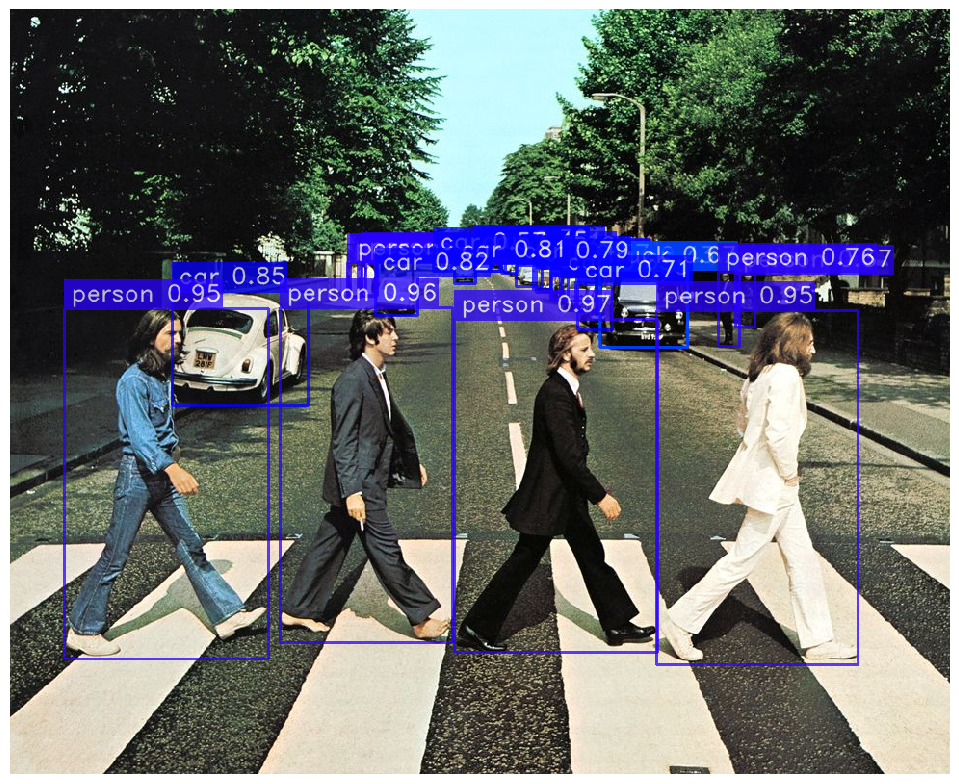

In [ ]:
import super_gradients

yolo_nas = super_gradients.training.models.get("yolo_nas_s", pretrained_weights="coco").cuda()
yolo_nas.predict("https://deci-pretrained-models.s3.amazonaws.com/sample_images/beatles-abbeyroad.jpg").show()

Before:


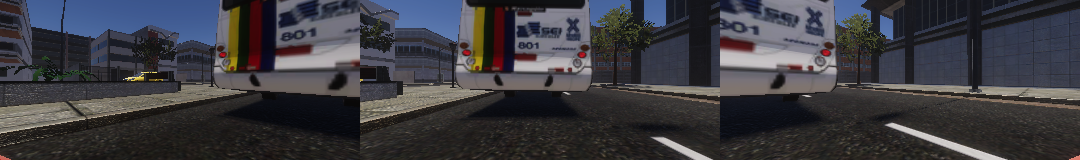

After:


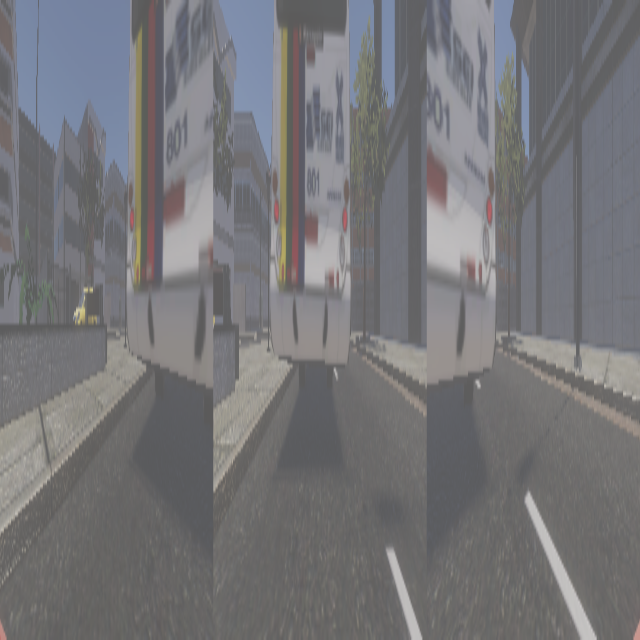

torch.Size([3, 640, 640])



0: 640x640 (no detections), 1218.9ms
Speed: 0.0ms preprocess, 1218.9ms inference, 7.6ms postprocess per image at shape (1, 3, 640, 640)


[ultralytics.yolo.engine.results.Results object with attributes:

boxes: ultralytics.yolo.engine.results.Boxes object
keypoints: None
keys: ['boxes']
masks: None
names: {0: 'person', 1: 'bicycle', 2: 'car', 3: 'motorcycle', 4: 'airplane', 5: 'bus', 6: 'train', 7: 'truck', 8: 'boat', 9: 'traffic light', 10: 'fire hydrant', 11: 'stop sign', 12: 'parking meter', 13: 'bench', 14: 'bird', 15: 'cat', 16: 'dog', 17: 'horse', 18: 'sheep', 19: 'cow', 20: 'elephant', 21: 'bear', 22: 'zebra', 23: 'giraffe', 24: 'backpack', 25: 'umbrella', 26: 'handbag', 27: 'tie', 28: 'suitcase', 29: 'frisbee', 30: 'skis', 31: 'snowboard', 32: 'sports ball', 33: 'kite', 34: 'baseball bat', 35: 'baseball glove', 36: 'skateboard', 37: 'surfboard', 38: 'tennis racket', 39: 'bottle', 40: 'wine glass', 41: 'cup', 42: 'fork', 43: 'knife', 44: 'spoon', 45: 'bowl', 46: 'banana', 47: 'apple', 48: 'sandwich', 49: 'orange', 50: 'broccoli', 51: 'carrot', 52: 'hot dog', 53: 'pizza', 54: 'donut', 55: 'cake', 56: 'chair', 57: '

In [ ]:
from ultralytics import YOLO

# Load a model
model = YOLO("yolov8n.pt")  # load a pretrained model (recommended for training)

# Use the model
# model.train(data="coco128.yaml", epochs=3)  # train the model
# metrics = model.val()  # evaluate model performance on the validation set
results = model(torch.unsqueeze(dataset[0][0], 0))  # predict on an image
print(results)